## **Introduction: Why Python**

#### **Ever Increasing Speeds. Frequencies, and Data Volumnes**

The one dimension of the finance industry that has been influenced most by technology is the speed and frequency with which financial transactions are decided and executed such as *flash trading* <br>

Increasing data availability on ever-smaller time scales makes it necessary to react in real time. The increasing speed and frequency of trading makes the data volumnes further increase. This leads to processes that reinforce each other and push the average time scale for financial transactions down. <br>

In comparison, on a typical trading day during a single trading hour the stock price of Apple Inc. (APPL) may be quoted 15,000 times compared to previously thirty years quote captured which is approximately 7,500 times.

#### **Real Time Analytics**

- Big Data
Demanding both increased computing power and ever larger memory and storage capacities.
- Real Time Economy
In the past, decision makers could reply on structured, regular planning as well as decision and risk management processes, whereas today they face the need to take care of these functions in real time.

#### **Finance and Python Syntax**

A major reason for people preferring python is because its syntax is quite close to the mathematical syntax used to describe scientific problems or financial algorithms. <br>

This can be illustrated by a financial Algorithm, called *Valuation of a European Call Option by Monte Carlo Simulation*. <br>
This considers a Black-Scholes-Merton (BSM) setup in which the option's underlying risk factor allows a geometric Brownian Motion.

**Numerical Parameters** <br>
- Initial Stock Index level S = 100
- Strike Price of the european call option K = 105
- Time to maturity T = 1 year
- Constant, riskless short rate r = 0.05
- Constant volatility = 0.2

![BSM Equation.png](<attachment:BSM Equation.png>)
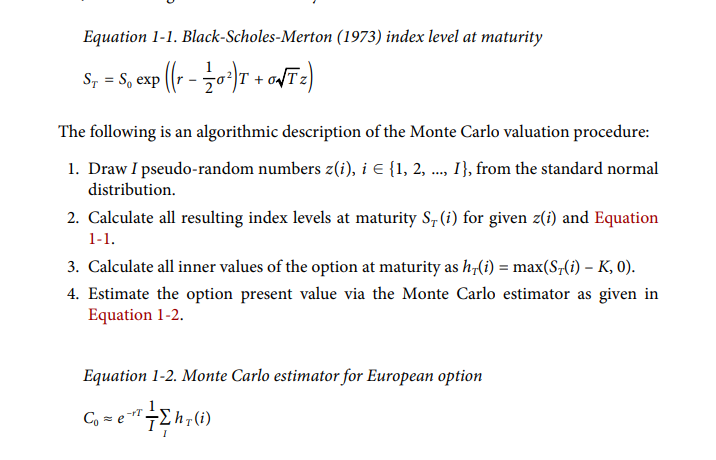

In [3]:
import math
import numpy as np

#Parameter values
S0 = 100
K = 105
T= 1.0
r = 0.05
sigma = 0.2

I = 100000 # Number of simulations
np.random.seed(1000)
z = np.random.standard_normal(I)

#Index values at maturity
ST = S0* np.exp((r-sigma ** 2/2)*T + sigma * math.sqrt(T)*z)
hT = np.maximum(ST - K, 0) # payoff at maturity
C0 = math.exp(-r*T)* np.mean(hT) # Monte-Carlo Estimator

print("Value of the European Call option: {:5.3f}".format(C0))

Value of the European Call option: 8.019


#### **Data Driven Finance**

The history of quantitative finance in large parts contradicts the scientific method. In many cases, theories and models have been developed on the basis of simplifying mathematical assumptions with the goal of discovering elegant answers to central problems in finance. Since these phenomenons are hardly ever found in financial markets, it should not come as a surprise that emperical evidence for the theories is lacking.

It has become quite straightforward to retrieve professional data on a large scale even on a local machine, making use of Python and a professional data subscription to the Eikon Data APIs, polygon client etc.<br>

In the example below, we extract crypto conditions.

In [10]:
from polygon import RESTClient
client = RESTClient("U497bdkeRBtfPT4EJd1TpHxAaWYjcOKM")  # POLYGON_API_KEY environment variable is used

for c in client.list_conditions("crypto", limit=1000):
    print(c)

Condition(abbreviation=None, asset_class='crypto', data_types=['trade'], description=None, exchange=None, id=0, legacy=None, name='Regular Trade', sip_mapping=None, type='regular', update_rules=None)
Condition(abbreviation=None, asset_class='crypto', data_types=['trade'], description='The asset was sold at the prevailing best bid price on an exchange.', exchange=None, id=1, legacy=None, name='Sell Side', sip_mapping=None, type='buy_or_sell_side', update_rules=None)
Condition(abbreviation=None, asset_class='crypto', data_types=['trade'], description='The asset was bought at the prevailing best ask price on an exchange.', exchange=None, id=2, legacy=None, name='Buy Side', sip_mapping=None, type='buy_or_sell_side', update_rules=None)


#### **AI in Finance**

In [21]:
import pathlib

notebook = pathlib.Path().resolve()
directory = notebook/"Data"

import numpy as np
import pandas as pd

data = pd.read_csv(directory/"eikon.csv", index_col=0, parse_dates=True)
data = pd.DataFrame(data["AAPL.O"])
data["Returns"] = np.log(data/data.shift())
data.dropna(inplace=True)
data.head()

,AAPL.O,Returns
Date,,
2010-01-05,30.625684,0.001727
2010-01-06,30.138541,-0.016034
2010-01-07,30.082827,-0.001850
2010-01-08,30.282827,0.006626
2010-01-11,30.015684,-0.008861


In [22]:
lags = 6
cols = []
for lag in range(1, lags+1):
    col = 'lag{}'.format(lag)
    data[col] = np.sign(data['Returns'].shift(lag))
    cols.append(col)
data.dropna(inplace=True)
data.head()

,AAPL.O,Returns,lag1,lag2,lag3,lag4,lag5,lag6
Date,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0
2010-01-19,30.719969,0.043288,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-20,30.246398,-0.015536,1.0,-1.0,-1.0,1.0,-1.0,-1.0


The above code does the following:
- Selects Historical end-of-day data for the Apple Inc Stock
- Calculates the log returns over the complete history
- Generates DataFrame columns with directional lagged log return data (-1 or +1)

<Axes: xlabel='Date'>

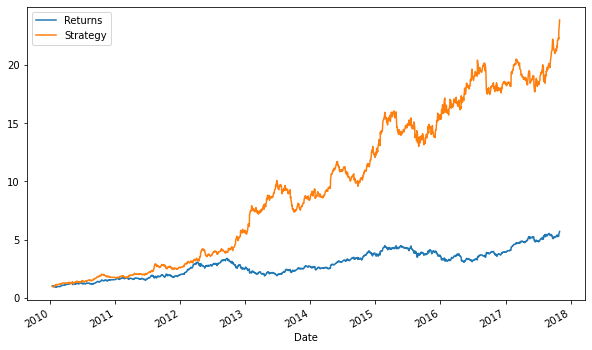

In [23]:
from sklearn.svm import SVC
model = SVC(gamma="auto")

model.fit(data[cols], np.sign(data['Returns']))
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma="auto",
    kernel="rbf", max_iter=1, probability=False, random_state=None, shrinking=True,
    tol = 0.001, verbose=False)

data["Prediction"] = model.predict(data[cols])
data["Strategy"] = data['Prediction'] * data["Returns"]
data[["Returns", "Strategy"]].cumsum().apply(np.exp).plot(figsize=(10,6))